# Xception Model Evaluation


The trained baseline and dropout Xception models are evaluated by doing inference on the test split of cross-datasets. To evaluate the application of Monte Carlo Dropout technique, each dropout model also does the inference with 50 Monte Carlo samples. The considered sample value is chosen based on the basic CNN Monte Carlo Sample experiments that resulted no significant performance aligning with the increasing Monte Carlo Sample that requires more computational cost. Each model's performance is interpreted by its ROC curve and AUC values.


In [1]:
from tensorflow.keras.applications import xception
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.metrics import roc_curve, auc, confusion_matrix
from matplotlib import pyplot as plt
from IPython.display import display
import tensorflow as tf
import pandas as pd
import numpy as np
import time
import os

%matplotlib inline

## Define Dataset Directory


In [2]:
CDF_DATASET_DIR = "/kaggle/input/deepfake-detection-datasets/Celeb-DF-v2/Test"
DF_DATASET_DIR = "/kaggle/input/deepfake-detection-datasets/DeeperForensics-1.0/Test"
DFDC_DATASET_DIR = "/kaggle/input/deepfake-detection-datasets/DFDC/Test"

## Define Trained Models Path


In [3]:
XCEPTION_MODEL_DIR = "/kaggle/input/xception-model-training"

In [4]:
baseline_xception_cdf_model_path = os.path.join(
    XCEPTION_MODEL_DIR, "baseline_xception_cdf_model.keras"
)
baseline_xception_df_model_path = os.path.join(
    XCEPTION_MODEL_DIR, "baseline_xception_df_model.keras"
)
baseline_xception_dfdc_model_path = os.path.join(
    XCEPTION_MODEL_DIR, "baseline_xception_dfdc_model.keras"
)

In [5]:
dropout_xception_cdf_model_path = os.path.join(
    XCEPTION_MODEL_DIR, "dropout_xception_cdf_model.keras"
)
dropout_xception_df_model_path = os.path.join(
    XCEPTION_MODEL_DIR, "dropout_xception_df_model.keras"
)
dropout_xception_dfdc_model_path = os.path.join(
    XCEPTION_MODEL_DIR, "dropout_xception_dfdc_model.keras"
)

## Load the Trained Models


In [6]:
baseline_xception_cdf_model = tf.keras.models.load_model(
    baseline_xception_cdf_model_path
)
baseline_xception_df_model = tf.keras.models.load_model(baseline_xception_df_model_path)
baseline_xception_dfdc_model = tf.keras.models.load_model(
    baseline_xception_dfdc_model_path
)

In [7]:
dropout_xception_cdf_model = tf.keras.models.load_model(dropout_xception_cdf_model_path)
dropout_xception_df_model = tf.keras.models.load_model(dropout_xception_df_model_path)
dropout_xception_dfdc_model = tf.keras.models.load_model(
    dropout_xception_dfdc_model_path
)

## File Video Id Extraction Function


In [8]:
def extract_file_id(filepath):
    return filepath.split("-")[0]

## Image Preprocessing Function


In [9]:
def preprocess_image(filepath):
    image = load_img(filepath, target_size=(128, 128))
    image = img_to_array(image)
    image = xception.preprocess_input(image)
    return image

## Get Dataset Metadata


In [10]:
def group_preprocessed_frames_by_file_id(dataset_dir, dataset_name):
    label_dirs = [
        os.path.join(dataset_dir, label) for label in ["Deepfake", "Original"]
    ]

    metadata = {"name": dataset_name, "videos": {}}

    for label_dir in label_dirs:
        label = 0 if label_dir.split("/")[-1] == "Deepfake" else 1
        for filename in os.listdir(label_dir):
            file_id = extract_file_id(filename)
            filepath = os.path.join(label_dir, filename)
            preprocessed_image = preprocess_image(filepath)

            if metadata["videos"].get(file_id) == None:
                metadata["videos"][file_id] = {"label": label, "data": []}

            metadata["videos"][file_id]["data"].append(preprocessed_image)

    return metadata

In [11]:
cdf_metadata = group_preprocessed_frames_by_file_id(
    CDF_DATASET_DIR, dataset_name="Celeb-DF-v2"
)
df_metadata = group_preprocessed_frames_by_file_id(
    DF_DATASET_DIR, dataset_name="DeeperForensics-1.0"
)
dfdc_metadata = group_preprocessed_frames_by_file_id(
    DFDC_DATASET_DIR, dataset_name="DFDC"
)

datasets = [cdf_metadata, df_metadata, dfdc_metadata]

## Evaluate Each Model in Cross Dataset


### Function to Get FPR, TPR, and AUC Metric Value of a Model's Prediction


In [12]:
def get_model_prediction_metrics_on_dataset(
    model,
    dataset_videos,
    mc_dropout=False,
    mc_sample_size=100,
):
    predictions = {"data_id": [], "y_true": [], "y_pred_score": []}

    for id in dataset_videos.keys():
        label = dataset_videos[id].get("label")
        predictions["y_true"].append(label)
        predictions["data_id"].append(id)

        images_data = np.array(dataset_videos[id].get("data"))
        if mc_dropout:
            mc_prediction_scores = np.stack(
                [model(images_data, training=True) for _ in range(mc_sample_size)]
            )
            frame_prediction_scores = np.mean(mc_prediction_scores, axis=0)
        else:
            frame_prediction_scores = model(images_data, training=False)

        video_prediction_score = np.mean(frame_prediction_scores)
        predictions["y_pred_score"].append(video_prediction_score)

    fpr, tpr, _ = roc_curve(
        predictions["y_true"],
        predictions["y_pred_score"],
        drop_intermediate=False,
    )
    roc_auc = auc(fpr, tpr)

    y_pred = (np.array(predictions["y_pred_score"]) > 0.5).astype(int)
    cm = confusion_matrix(predictions["y_true"], y_pred).ravel()

    return fpr, tpr, roc_auc, cm, predictions

### Model Evaluation Function


In [13]:
def evaluate_model_on_cross_datasets(
    model,
    datasets,
    mc_dropout=False,
    mc_sample_size=100,
    model_name="Model",
):
    cm_data = {
        "Dataset": [],
        "TN": [],
        "FP": [],
        "FN": [],
        "TP": [],
    }

    prediction_data = {"dataset": [], "data_id": [], "y_true": [], "y_pred_score": []}

    plot_colors = ["dodgerblue", "red", "forestgreen"]

    plt.plot([0, 1], [0, 1], color="lightsteelblue", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{model_name} ROC Curve")

    for i, dataset in enumerate(datasets):
        start_time = time.time()
        dataset_name = dataset.get("name")
        print(f"Evaluating on {dataset_name}...")
        fpr, tpr, roc_auc, cm, predictions = get_model_prediction_metrics_on_dataset(
            model,
            dataset.get("videos"),
            mc_dropout,
            mc_sample_size,
        )
        print(f"=> Finished in {round(time.time() - start_time, 3)} seconds\n")

        plt.plot(
            fpr,
            tpr,
            color=plot_colors[i],
            label=f"{dataset_name} (AUC = {round(roc_auc, 3)})",
        )

        prediction_data["dataset"].extend(
            [dataset_name for _ in range(len(predictions.get("data_id")))]
        )
        prediction_data["data_id"].extend(predictions.get("data_id"))
        prediction_data["y_true"].extend(predictions.get("y_true"))
        prediction_data["y_pred_score"].extend(predictions.get("y_pred_score"))

        tn, fp, fn, tp = cm
        cm_data["Dataset"].append(dataset_name)
        cm_data["TN"].append(tn)
        cm_data["FP"].append(fp)
        cm_data["FN"].append(fn)
        cm_data["TP"].append(tp)

    plt.legend(loc="lower right")
    plt.show()

    cm_df = pd.DataFrame(cm_data)
    display(cm_df)

    prediction_data_df = pd.DataFrame(prediction_data)
    prediction_data_filename = (
        model_name.lower().replace(" ", "-") + "-predictions" + ".csv"
    )
    prediction_data_df.to_csv(prediction_data_filename, index=False)

### Models Evaluation


In [14]:
x = baseline_xception_cdf_model(
    np.array(datasets[0]["videos"]["id25_id24_0002"]["data"])
)
del x

#### Trained on Celeb-DF-v2


##### Baseline Model


Evaluating on Celeb-DF-v2...
=> Finished in 5.101 seconds

Evaluating on DeeperForensics-1.0...
=> Finished in 5.047 seconds

Evaluating on DFDC...
=> Finished in 4.933 seconds



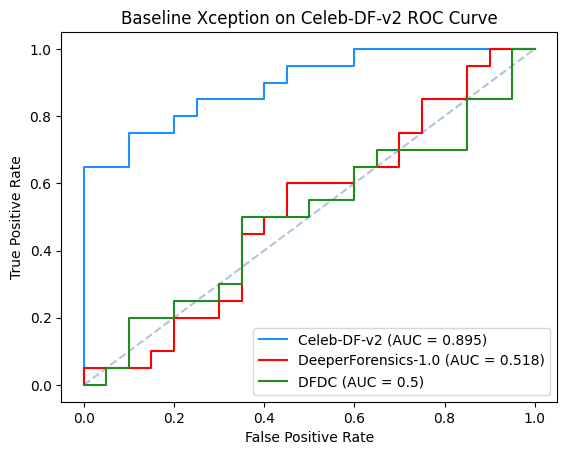

,Dataset,TN,FP,FN,TP
0,Celeb-DF-v2,18,2,7,13
1,DeeperForensics-1.0,8,12,8,12
2,DFDC,12,8,10,10


CPU times: user 15 s, sys: 566 ms, total: 15.6 s
Wall time: 15.4 s


In [15]:
%%time
evaluate_model_on_cross_datasets(
    baseline_xception_cdf_model,
    datasets,
    model_name="Baseline Xception on Celeb-DF-v2"
)

##### Dropout Model


Evaluating on Celeb-DF-v2...
=> Finished in 4.721 seconds

Evaluating on DeeperForensics-1.0...
=> Finished in 4.728 seconds

Evaluating on DFDC...
=> Finished in 4.728 seconds



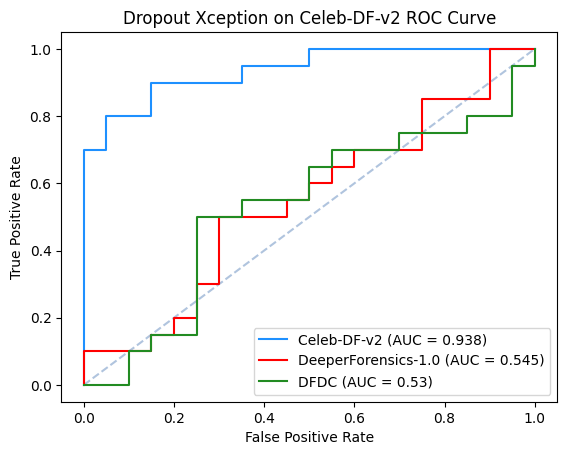

,Dataset,TN,FP,FN,TP
0,Celeb-DF-v2,20,0,9,11
1,DeeperForensics-1.0,12,8,10,10
2,DFDC,15,5,11,9


CPU times: user 14.7 s, sys: 209 ms, total: 14.9 s
Wall time: 14.6 s


In [16]:
%%time
evaluate_model_on_cross_datasets(
    dropout_xception_cdf_model,
    datasets,
    model_name="Dropout Xception on Celeb-DF-v2"
)

##### Monte Carlo Dropout Model


Evaluating on Celeb-DF-v2...
=> Finished in 232.21 seconds

Evaluating on DeeperForensics-1.0...
=> Finished in 231.908 seconds

Evaluating on DFDC...
=> Finished in 232.055 seconds



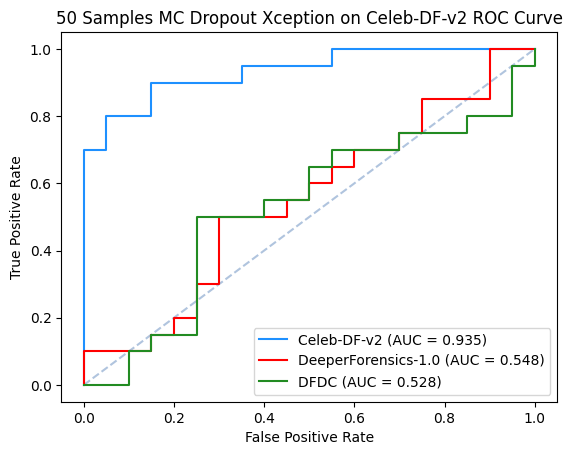

,Dataset,TN,FP,FN,TP
0,Celeb-DF-v2,20,0,9,11
1,DeeperForensics-1.0,12,8,10,10
2,DFDC,15,5,11,9


CPU times: user 11min 34s, sys: 3.34 s, total: 11min 38s
Wall time: 11min 36s


In [17]:
%%time
evaluate_model_on_cross_datasets(
    dropout_xception_cdf_model,
    datasets,
    mc_dropout=True,
    mc_sample_size=50,
    model_name="50 Samples MC Dropout Xception on Celeb-DF-v2"

)

#### Trained on DeeperForensics-1.0


##### Baseline Model


Evaluating on Celeb-DF-v2...
=> Finished in 5.138 seconds

Evaluating on DeeperForensics-1.0...
=> Finished in 5.112 seconds

Evaluating on DFDC...
=> Finished in 5.032 seconds



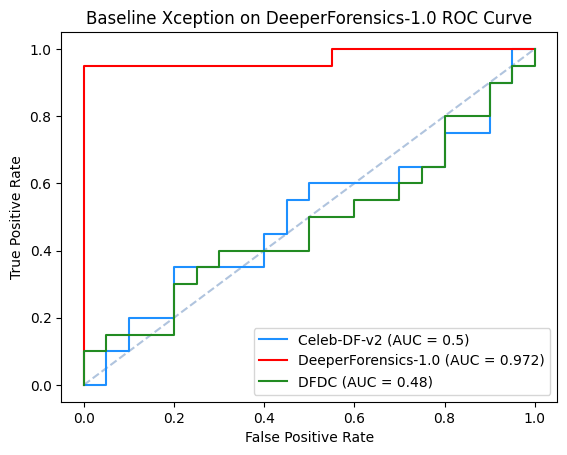

,Dataset,TN,FP,FN,TP
0,Celeb-DF-v2,4,16,6,14
1,DeeperForensics-1.0,20,0,3,17
2,DFDC,7,13,9,11


CPU times: user 14.5 s, sys: 1.3 s, total: 15.8 s
Wall time: 15.5 s


In [20]:
%%time
evaluate_model_on_cross_datasets(
    baseline_xception_df_model,
    datasets,
    model_name="Baseline Xception on DeeperForensics-1.0"
)

##### Dropout Model


Evaluating on Celeb-DF-v2...
=> Finished in 5.076 seconds

Evaluating on DeeperForensics-1.0...
=> Finished in 5.055 seconds

Evaluating on DFDC...
=> Finished in 5.088 seconds



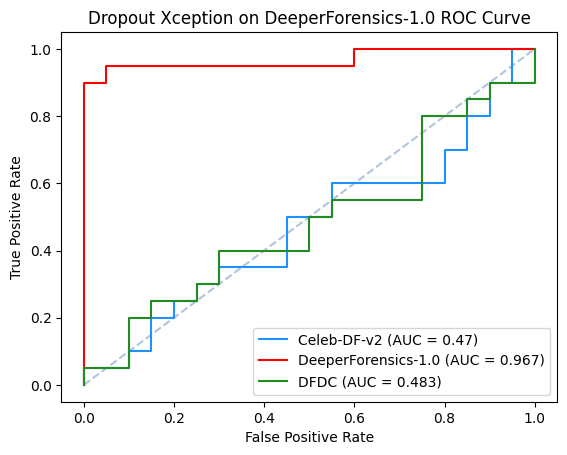

,Dataset,TN,FP,FN,TP
0,Celeb-DF-v2,4,16,6,14
1,DeeperForensics-1.0,20,0,3,17
2,DFDC,7,13,9,11


CPU times: user 14.5 s, sys: 1.29 s, total: 15.7 s
Wall time: 15.5 s


In [21]:
%%time
evaluate_model_on_cross_datasets(
    dropout_xception_df_model,
    datasets,
    model_name="Dropout Xception on DeeperForensics-1.0"
)

##### Monte Carlo Dropout Model


Evaluating on Celeb-DF-v2...
=> Finished in 234.335 seconds

Evaluating on DeeperForensics-1.0...
=> Finished in 228.896 seconds

Evaluating on DFDC...
=> Finished in 227.23 seconds



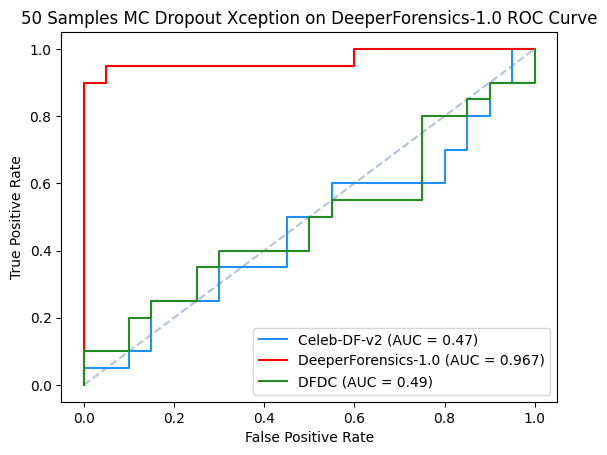

,Dataset,TN,FP,FN,TP
0,Celeb-DF-v2,4,16,6,14
1,DeeperForensics-1.0,20,0,3,17
2,DFDC,7,13,9,11


CPU times: user 11min 27s, sys: 5.39 s, total: 11min 32s
Wall time: 11min 30s


In [22]:
%%time
evaluate_model_on_cross_datasets(
    dropout_xception_df_model,
    datasets,
    mc_dropout=True,
    mc_sample_size=50,
    model_name="50 Samples MC Dropout Xception on DeeperForensics-1.0"
)

#### Trained on DFDC


##### Baseline Model


Evaluating on Celeb-DF-v2...
=> Finished in 5.004 seconds

Evaluating on DeeperForensics-1.0...
=> Finished in 5.081 seconds

Evaluating on DFDC...
=> Finished in 5.005 seconds



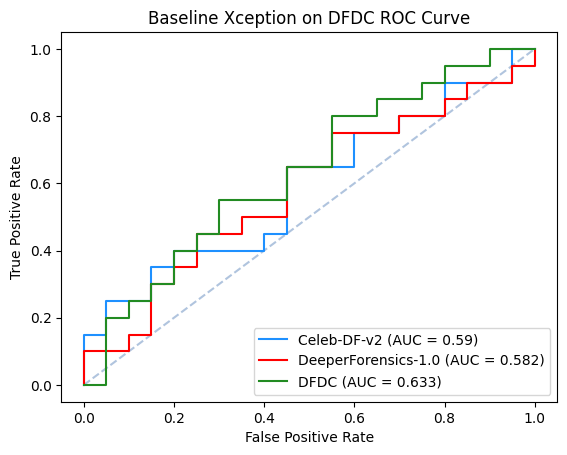

,Dataset,TN,FP,FN,TP
0,Celeb-DF-v2,11,9,7,13
1,DeeperForensics-1.0,4,16,3,17
2,DFDC,9,11,7,13


CPU times: user 14.4 s, sys: 1.26 s, total: 15.6 s
Wall time: 15.3 s


In [25]:
%%time
evaluate_model_on_cross_datasets(
    baseline_xception_dfdc_model,
    datasets,
    model_name="Baseline Xception on DFDC"
)

##### Dropout Model


Evaluating on Celeb-DF-v2...
=> Finished in 4.986 seconds

Evaluating on DeeperForensics-1.0...
=> Finished in 4.969 seconds

Evaluating on DFDC...
=> Finished in 4.972 seconds



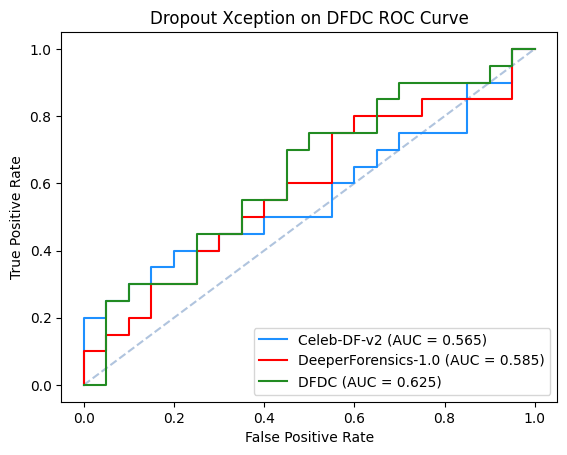

,Dataset,TN,FP,FN,TP
0,Celeb-DF-v2,14,6,11,9
1,DeeperForensics-1.0,3,17,3,17
2,DFDC,11,9,7,13


CPU times: user 14.1 s, sys: 1.26 s, total: 15.4 s
Wall time: 15.1 s


In [26]:
%%time
evaluate_model_on_cross_datasets(
    dropout_xception_dfdc_model,
    datasets,
    model_name="Dropout Xception on DFDC"
)

##### Monte Carlo Dropout Model


Evaluating on Celeb-DF-v2...
=> Finished in 227.012 seconds

Evaluating on DeeperForensics-1.0...
=> Finished in 226.46 seconds

Evaluating on DFDC...
=> Finished in 225.419 seconds



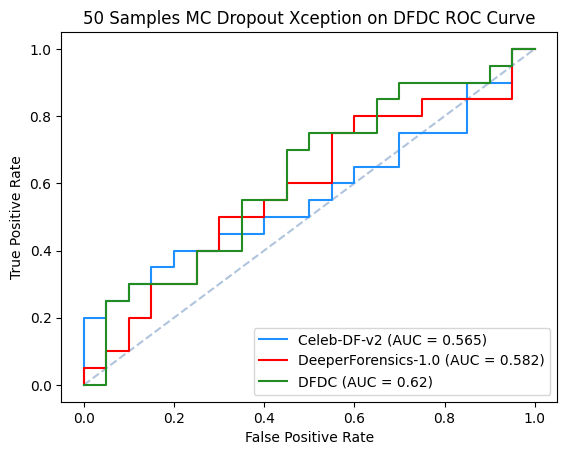

,Dataset,TN,FP,FN,TP
0,Celeb-DF-v2,14,6,11,9
1,DeeperForensics-1.0,3,17,3,17
2,DFDC,11,9,7,13


CPU times: user 11min 15s, sys: 5.77 s, total: 11min 20s
Wall time: 11min 19s


In [27]:
%%time
evaluate_model_on_cross_datasets(
    dropout_xception_dfdc_model,
    datasets,
    mc_dropout=True,
    mc_sample_size=50,
    model_name="50 Samples MC Dropout Xception on DFDC"
)